In [3]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from torch import optim
import torch.nn.functional as  F
import cv2

from Image_Sampler import Sampler

PATH = "/disk/vanishing_data/is789/models/small_layers_bigZ/"
IMG_TRAIN = "/disk/vanishing_data/is789/anomaly_samples/train_set/"
IMG_TEST = "/disk/vanishing_data/is789/anomaly_samples/40test/"

epoch = 1000
BATCH_SIZE = 35
imgSize=512
zDim=512
learning_rate = 1e-05

In [4]:
print("Loading data...")
train_data = Sampler.load_Images(IMG_TRAIN).astype("float32") / 255

test_data = Sampler.load_Images(IMG_TEST).astype("float32") / 255


Loading data...
Loaded 2500 images | width = 512, height = 512, channels = 3
Loaded 40 images | width = 512, height = 512, channels = 3


In [5]:
## transpose images
def discardLabels(data):
    new_data = []
    for img in data:
#         img = img.numpy()
        img = np.transpose(img, (2,1,0))
        new_data.append(img)
        
        
    return np.array(new_data)

train_data = torch.as_tensor(discardLabels(train_data))
test_data = torch.as_tensor(discardLabels(test_data))

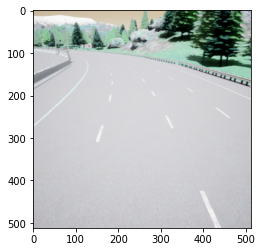

In [6]:
img = train_data[2]
img = img.numpy()
img = np.transpose(img, (2,1,0))
plt.imshow(img)

In [7]:
## apply noise
noise_set = []
x = 0
for img in train_data:
    pic = img.numpy().copy()
    pic[:,200:350,250:310] = 0.0
    noise_set.append(pic)
    x +=1
    if x == 100:
        break

noise_set = np.array(noise_set)
noise_set = torch.as_tensor(noise_set)
noise_set.shape

torch.Size([100, 3, 512, 512])

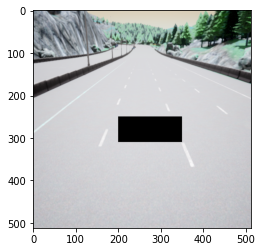

In [8]:
## show noisy image

img = noise_set[11]
# img = img.squeeze()
img = img.numpy()
img = np.transpose(img, (2,1,0))
plt.imshow(img)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [10]:

class VAE(nn.Module):
    
    def __init__(self, imgChannels=3, imgSize=imgSize, zDim=zDim):
        super(VAE, self).__init__()
        
        stride=2
        in_padding=[0,0,0,0,0]
        out_padding=[0,0,0,0,1]
        kernel=3
        layers=[32, 64, 128, 128, 256]
#         layers=[128, 128, 128, 256, 256]

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(in_channels=imgChannels, out_channels=layers[0], kernel_size=kernel, stride=stride, padding=in_padding[0])
        self.encBn1 = nn.BatchNorm2d(layers[0])
        self.encConv2 = nn.Conv2d(in_channels=layers[0], out_channels=layers[1], kernel_size=kernel, stride=stride, padding=in_padding[1])
        self.encBn2 = nn.BatchNorm2d(layers[1])
        self.encConv3 = nn.Conv2d(in_channels=layers[1], out_channels=layers[2], kernel_size=kernel, stride=stride, padding=in_padding[2])
        self.encBn3 = nn.BatchNorm2d(layers[2])
        self.encConv4 = nn.Conv2d(in_channels=layers[2], out_channels=layers[3], kernel_size=kernel, stride=stride, padding=in_padding[3])
        self.encBn4 = nn.BatchNorm2d(layers[3])
        self.encConv5 = nn.Conv2d(in_channels=layers[3], out_channels=layers[4], kernel_size=kernel, stride=stride, padding=in_padding[3])
        self.encBn5 = nn.BatchNorm2d(layers[4])
        
        encoderDims = self.calcEncoderDims(len(layers), imgSize, kernel, in_padding, stride)
        featureDim = layers[-1] * encoderDims[-1] * encoderDims[-1]
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decBn1 = nn.BatchNorm1d(featureDim)
        self.decConv1 = nn.ConvTranspose2d(in_channels=layers[4], out_channels=layers[3], kernel_size=kernel, stride=stride, output_padding=out_padding[0])
        self.decBn2 = nn.BatchNorm2d(layers[3])
        self.decConv2 = nn.ConvTranspose2d(in_channels=layers[3], out_channels=layers[2], kernel_size=kernel, stride=stride, output_padding=out_padding[1])
        self.decBn3 = nn.BatchNorm2d(layers[2])
        self.decConv3 = nn.ConvTranspose2d(in_channels=layers[2], out_channels=layers[1], kernel_size=kernel, stride=stride, output_padding=out_padding[2])
        self.decBn4 = nn.BatchNorm2d(layers[1])
        self.decConv4 = nn.ConvTranspose2d(in_channels=layers[1], out_channels=layers[0], kernel_size=kernel, stride=stride, output_padding=out_padding[3])
        self.decBn5 = nn.BatchNorm2d(layers[0])
        self.decConv5 = nn.ConvTranspose2d(in_channels=layers[0], out_channels=imgChannels, kernel_size=kernel, stride=stride, output_padding=out_padding[4])
        
        self.final_encoder_dim = None
        
        decoderDims = self.calcDecoderDims(len(layers), encoderDims[-1], kernel, in_padding, out_padding, stride)
        self.printModel(layers, encoderDims, decoderDims, imgSize, imgChannels)

    def calcEncoderDims(self, layer_size, imageSize, kernel, in_padding, stride):
        newDims = [imageSize]
        for x in range(layer_size):
            tmpSize = int((newDims[-1]-kernel+2*in_padding[x])/stride)+1
            newDims.append(tmpSize)
        newDims.pop(0)
        return newDims
    
    def calcDecoderDims(self, layer_size, imageSize, kernel, in_padding, out_padding, stride, d=1):
        newDims = [imageSize]
        for x in range(layer_size):
            tmpSize = (newDims[-1] - 1)*stride - 2*in_padding[x] + d*(kernel - 1) + out_padding[x] + 1
            newDims.append(tmpSize)
#         newDims.pop(0)
        return newDims
    
    
    def printModel(self, layers, encDims, decDims, imageSize, imgChannels):
        print("=============")
        print("Image Flow:")
        print("Encoder:")
        print(f"{imageSize}x{imageSize}x{imgChannels} (Input Image)")
        for x in range(len(layers)):
            print(f"{encDims[x]}x{encDims[x]}x{layers[x]}")
        
        print("Decoder:")
        k = len(layers) - 1
        for x in range(len(layers)):
            print(f"{decDims[x]}x{decDims[x]}x{layers[k]}")
            k = k - 1
        print(f"{decDims[-1]}x{decDims[-1]}x{imgChannels} (Output Image)")
        print("=============")
            
        
    def encoder(self, x):

        x = F.relu(self.encConv1(x))
        x = self.encBn1(x)
#         print(x.size())
        x = F.relu(self.encConv2(x))
        x = self.encBn2(x)
#         print(x.size())
        x = F.relu(self.encConv3(x))
        x = self.encBn3(x)
#         print(x.size())
        x = F.relu(self.encConv4(x))
        x = self.encBn4(x)
        x = F.relu(self.encConv5(x))
        x = self.encBn5(x)
#         print(x.size())
        self.final_encoder_dim = np.array([x.size(1), x.size(2), x.size(3)])
        flatten = np.prod(self.final_encoder_dim)

        x = x.view(-1, flatten)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = self.decBn1(x)
        #print(x.size())
        x = x.view(-1, self.final_encoder_dim[0], self.final_encoder_dim[1], self.final_encoder_dim[2])
        x = F.relu(self.decConv1(x))
        #print(x.size())
        x = self.decBn2(x)
        x = F.relu(self.decConv2(x))
        x = self.decBn3(x)
        #print(x.size())
        x = F.relu(self.decConv3(x))
        x = self.decBn4(x)
        #print(x.size())
        x = F.relu(self.decConv4(x))
        x = self.decBn5(x)
        #print(x.size())
        x = torch.sigmoid(self.decConv5(x))
        #print(x.size())
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [11]:
model = VAE()
model.to(device)
# model.load_state_dict(torch.load(PATH + "model.pt"))
model.load_state_dict(torch.load("/disk/vanishing_data/is789/models/carla_512.pt"))

Image Flow:
Encoder:
512x512x3 (Input Image)
255x255x32
127x127x64
63x63x128
31x31x128
15x15x256
Decoder:
15x15x256
31x31x128
63x63x128
127x127x64
255x255x32
512x512x3 (Output Image)


<All keys matched successfully>

cuda


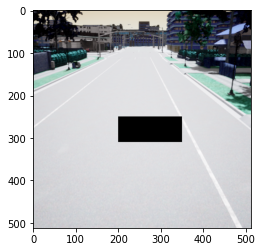

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from torch.utils.data import DataLoader

dataloaders = {}
dataloaders["train"] = DataLoader(dataset=train_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)

dataloaders["test"] = DataLoader(dataset=test_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)

dataloaders["noise"] = DataLoader(dataset=noise_set,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)

images = next(iter(dataloaders["noise"]))
plt.imshow(np.transpose(images[0], (2,1,0)))


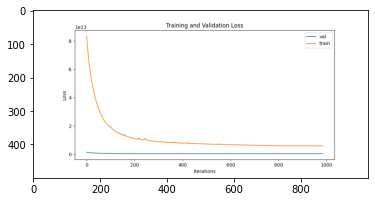

In [13]:
loss_plot = plt.imread(PATH + "loss_plot.png")
plt.imshow(loss_plot)

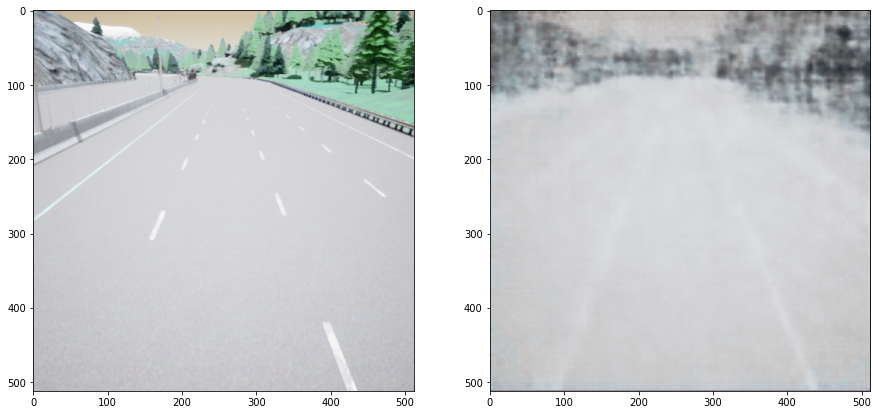

In [25]:
import random

model.eval()
with torch.no_grad():
    for imgs in random.sample(list(dataloaders["train"]), 1):
        imgs = imgs.to(device)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
        img = imgs[0].cpu().numpy()
        img = np.transpose(img, (2,1,0))

        ax1.imshow(img)
        out, mu, logVAR = model(imgs)

        out = out[0].cpu().numpy()
        out = np.transpose(out, (2,1,0))

        ax2.imshow(out)
        plt.savefig("eval_pic.png")
        break

In [15]:
def printReconError(img_in, img_out, threshold=None):
    img_in = img_in.dot([0.07, 0.72, 0.21])
    img_out = img_out.dot([0.07, 0.72, 0.21])
    errorMatrix = np.absolute(img_in - img_out)
    if not threshold == None:
        errorMatrix[errorMatrix < threshold] = 0.0
    errorAvg = np.sum(errorMatrix) / (errorMatrix.shape[0] * errorMatrix.shape[1])
    print(f"MAE: {errorAvg}")
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
    
    ax1.set_title("Original")
    ax1.imshow(img_in, cmap="gray")
    ax1.axis("off")
    ax2.set_title("Recreation")
    ax2.imshow(img_out, cmap="gray")
    ax2.axis("off")
    ax3.set_title("ErrorMap")
    ax3.imshow(errorMatrix, cmap="gray")
    ax3.axis("off")
    plt.savefig("error_map.png")

torch.Size([35, 3, 512, 512])
MAE: 0.04995393359170006


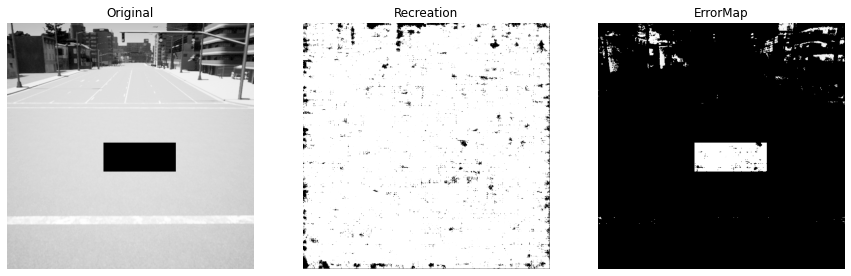

In [16]:
import random

# model.eval()
with torch.no_grad():
    for imgs in random.sample(list(dataloaders["noise"]), 1):
        print(imgs.shape)
        imgs = imgs.to(device)
#         plt.subplot(121)
        img = imgs[0].cpu().numpy()
        img = np.transpose(img, (2,1,0))
#         plt.imshow(img, cmap="gray")
        
        out, mu, logVAR = model(imgs)
#         plt.subplot(122)
        out = out[0].cpu().numpy()
        out = np.transpose(out, (2,1,0))
#         plt.imshow(out, cmap="gray")
        
        printReconError(img, out, 0.9)
        break

In [17]:
def evalOnSet(data):
    avg_MSE = 0
    for img in data:
        true_img = img.numpy()
        img = np.array([true_img])
        img = torch.as_tensor(img)
        img = img.to(device)
        out, _, _ = model(img)
        out = out[0].detach().cpu().numpy()
        errorMatrix = np.absolute(true_img - out)
        errorAvg = np.sum(errorMatrix) / (errorMatrix.shape[0] * errorMatrix.shape[1] * errorMatrix.shape[2])
        avg_MSE += errorAvg
    return avg_MSE / len(data)
        

In [18]:
evalOnSet(test_data)

0.05995642667015392

In [19]:
def add_model_prediction(true_image):
    true_image = np.transpose(true_image, (2,1,0))
    img = np.array([true_image])
    img = torch.as_tensor(img)
    img = img.to(device)
    out, _, _ = model(img)
    out = out[0].detach().cpu().numpy()
    
    seperator = np.zeros((3,20,512))
    
    final_img = np.concatenate((true_image, seperator, out), axis=1)
    final_img = np.transpose(final_img, (2,1,0))
    return final_img
    
    

In [21]:
sampler = Sampler(s_width=512, s_height=512, cam_height=4, cam_zoom=50, cam_rotation=-18)
images = sampler.sample_Ride(world_model="Town05_Opt", num_of_snaps=140, tick_rate=0.1)
storagePath = "/disk/vanishing_data/is789/anomaly_samples/video_images/"
path_list = Sampler.get_image_paths(storagePath)
for path in path_list:
    os.remove(path)
if not os.path.isdir(storagePath):
    os.mkdir(storagePath)
    
tmp = images
images = []
for image in tmp:
    model_predict = add_model_prediction(image)
    images.append(model_predict)
    
image_index = 0
images = np.array(images)
images = (images * 255).astype("int")
for k in range(len(images)):
    fill_index = image_index
    if image_index < 10:
        fill_index = "00"+str(image_index)
    elif image_index < 100:
        fill_index = "0"+str(image_index)
    cv2.imwrite(storagePath + f"snap_{fill_index}.png", images[k]) 
    # plt.imsave(storagePath + f"snap_{image_index}.png",images[k], format="png")
    image_index = image_index + 1

In [ ]:
plt.imshow(images[0])
images[0].shape

In [22]:
import cv2
def vae_in_action():
    path_list = sorted(Sampler.get_image_paths(storagePath))
    video = cv2.VideoWriter("example_ride.avi", 0, 10, (1044,512))
    for path in path_list:
        video.write(cv2.imread(path))
    cv2.destroyAllWindows()
    return video.release()

In [23]:
test = vae_in_action()